In [233]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as sim
import scipy.ndimage as sim


import mltools.utils.cuda_tools as cuda_tools
from mltools.networks import networks

device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import models
import importlib
importlib.reload(utils)

plt.rcParams.update({'font.size': 18})

memory_available [43319]
best GPU: 0


In [234]:
suffix=""
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/*/seed=*"):
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/sep_col=0.2_sep_size=0.3/seed=4*"):
#for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt3/sep_col=0.2_sep_size=0.3/*"):
#for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt4/*/*"):
#for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt5/*/*"):
#for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt6/*/*"):
#for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt7/*/*"):
for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt8/*/*"):
#for fol in glob.glob("../data/images_1/2x2_final2/col_sweep/*/seed=*"):
    seed=int(fol.split("seed=")[1])
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    plot_data_file=os.path.join(fol,f"plot_data{suffix}.pth")
    plot_data=torch.load(plot_data_file)
    plot_data["seed"]=seed
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
len(plot_datass),c

(1, 5)

In [235]:
plot_datass.keys()

dict_keys([('0.2', '0.4')])

In [236]:
plot_datas=plot_datass[list(plot_datass.keys())[0]]
save_steps=np.array(plot_datas[0]["save_steps"])

In [237]:
cmap="gnuplot"
cmap="rainbow"
norm = mcolors.Normalize(vmin=0.1, vmax=0.8)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

In [238]:
sel=["0.2"]#0.174

min step 1574
star step [2877]


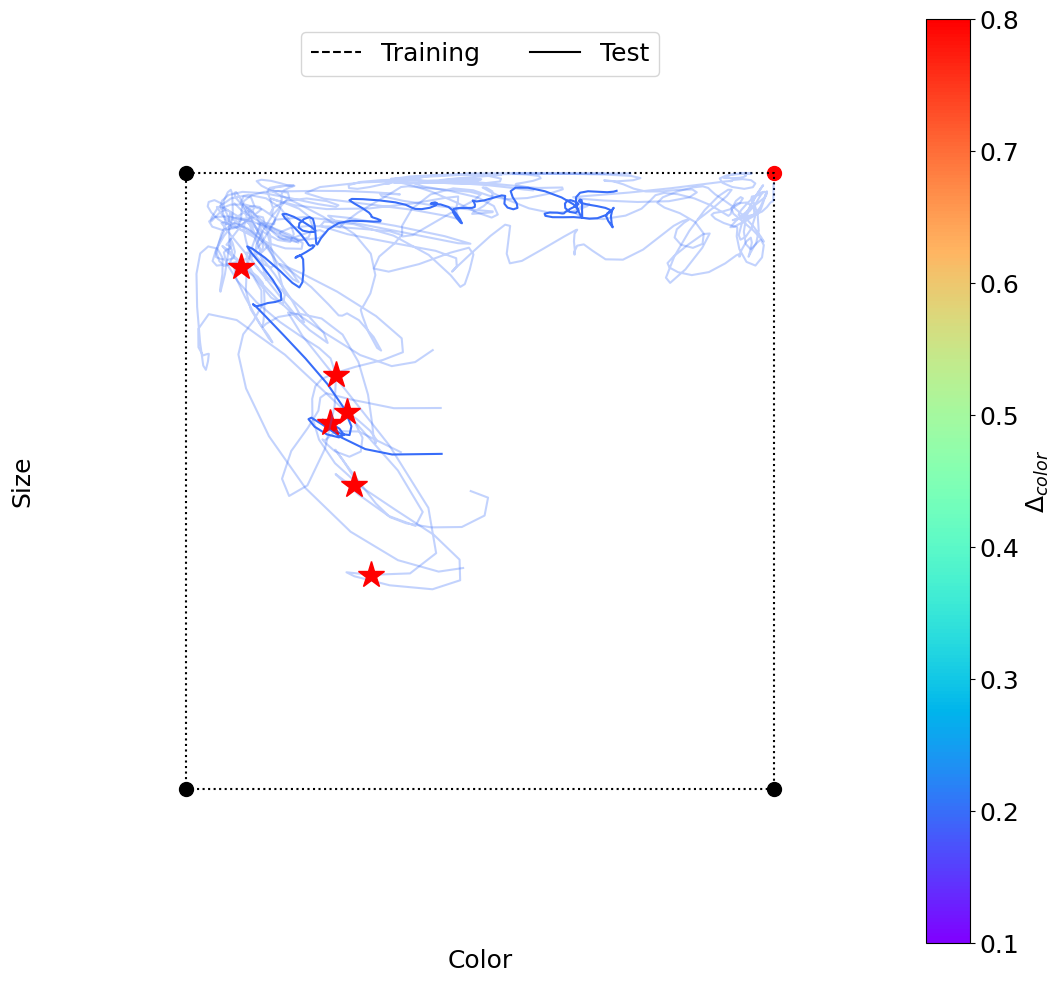

In [239]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)

i_step_min=7
print("min step",save_steps[i_step_min])

sigma_smooth=2.0

plot_mean=True
seeds=[0,1,2,3,4]
seeds_avg=[0,100,200,300,400]
seeds_avg=[0,100,200,300,400]

plot_train=False

plot_star=True
i_stars=[20]#[60,70,80,90]
print("star step",save_steps[i_stars])

plot_singles=True
single_seeds=[0,1,2,3,4]
single_seeds=[0,100,200,300,400]

tr_accs=[]
trajs_trss=[]
te_accs=[]
trajs_tess=[]
sep_cols=[]
sep_sizes=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_size=key[1]
    #cfg=float(key[2])
    sep_cols.append(float(sep_col))
    sep_sizes.append(float(sep_size))
    #if  sep_col!="0.2" or sep_size!="0.3":
    #    continue
    if sep_col not in sel:
        continue
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    seeds=[]
    for plot_data in plot_datas:
        if plot_data["seed"] not in seeds_avg:
            continue
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
        seeds.append(plot_data["seed"])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    tr_accs_=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
        gt=np.array([[0,0],[0,1],[1,0]][i])
        tr_accs_.append(1-np.abs(gt[None,None,:,None]-classprobs_pred_trs[:,:,:,l_tr==i]).mean(3))
    trajs_trs=np.stack(trajs_trs,axis=0)
    tr_accs.append(np.stack(tr_accs_,axis=0))
    #in 2D only 1 test
    te_accs.append(classprobs_pred_tes[:,:,:,l_te==3].mean(3))
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,sigma_smooth,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,sigma_smooth,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    color=sep_col_to_color(sep_col,cmap=cmap)
    #color=cfg_to_color(cfg,cmap=cmap)

    if plot_mean:
        plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],c=color,markersize=5)
        if plot_train:
            for i in range(3):
                plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
        if plot_star:
            plt.plot(trajs_te[i_stars,0],trajs_te[i_stars,1],marker="*",c="r",markersize=20)
            if plot_train:
                for i in range(3):
                    plt.scatter(trajs_trs[i,i_stars,0],trajs_trs[i,i_stars,1],marker="*",c="r",markersize=20)

    if plot_singles:
        for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
            seed=seeds[i_seed]
            if seed not in single_seeds:
                continue
            traj_smooth=sim.gaussian_filter1d(traj_te_single,sigma_smooth,axis=0,truncate=6.0)
            plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.3)
            #plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        if plot_train:
            for i in range(3):
                for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                    seed=seeds[i_seed]
                    if seed not in single_seeds:
                        continue
                    traj_smooth=sim.gaussian_filter1d(traj_tr_single,sigma_smooth,axis=0,truncate=6.0)
                    plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
                    #plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        if plot_star:
            for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
                seed=seeds[i_seed]
                if seed not in single_seeds:
                    continue
                traj_smooth=sim.gaussian_filter1d(traj_te_single,sigma_smooth,axis=0,truncate=6.0)
                plt.plot(traj_smooth[i_stars,0],traj_smooth[i_stars,1],marker="*",c="r",markersize=20)
            if plot_train:
                for i in range(3):
                    for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                        seed=seeds[i_seed]
                        if seed not in single_seeds:
                            continue
                        traj_smooth=sim.gaussian_filter1d(traj_tr_single,sigma_smooth,axis=0,truncate=6.0)
                        plt.plot(traj_smooth[i_stars,0],traj_smooth[i_stars,1],marker="*",c="r",markersize=20)
tr_accs=np.stack(tr_accs,axis=0)
te_accs=np.stack(te_accs,axis=0)
trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
sep_cols=np.array(sep_cols)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_cfg)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta_{color}$")
#cbar.set_label(r"$w_{cfg}$")

In [240]:
tr_accs_joint=tr_accs.prod(-1)
te_accs_joint=te_accs.prod(-1)
tr_accs.shape,te_accs.shape,tr_accs_joint.shape,te_accs_joint.shape

((1, 3, 5, 210, 2), (1, 5, 210, 2), (1, 3, 5, 210), (1, 5, 210))

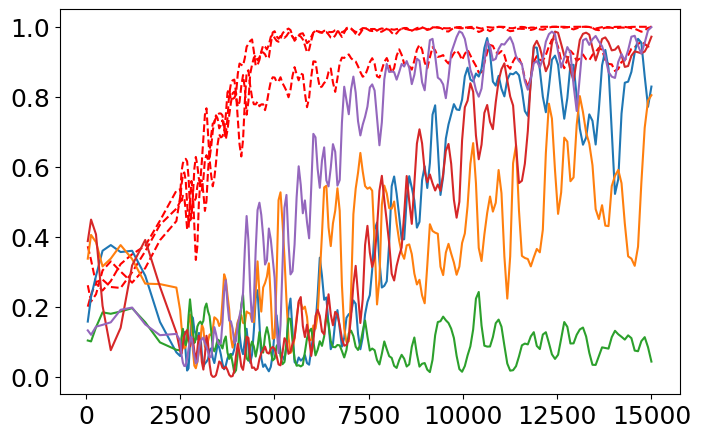

In [241]:
sigma_smooth=1.0

plt.figure(figsize=(8,5))
for tr_acc in tr_accs_joint[0]:
    smooth=sim.gaussian_filter1d(tr_acc.mean(0),sigma_smooth,axis=0,truncate=6.0)
    plt.plot(save_steps,smooth,c="r",ls="--")
for te_acc in te_accs_joint[0]:
    smooth=sim.gaussian_filter1d(te_acc,sigma_smooth,axis=0,truncate=6.0)
    plt.plot(save_steps,smooth)

In [242]:
classifier_ckpt_path="../data/images_1/2x2_final2/classifier_combined.pth"
n_classes=[2,2]
net=networks.CUNet(shape=(3,32,32),out_channels=64,chs=[32,32,32],norm_groups=4)
classifier=models.Classifier(net=net,n_classes=n_classes)
classifier=classifier.to(device)
classifier.load_state_dict(torch.load(classifier_ckpt_path))
classifier=classifier.eval()

In [245]:
for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt8/*/*"):
    seed=int(fol.split("seed=")[1])
    config=utils.load_config(glob.glob(os.path.join(fol,"*.yaml"))[0])
    break
config["data_params"]["color"]["means"],config["data_params"]["size"]["means"]

([[0.6, 0.4, 0.4], [0.4, 0.4, 0.6]], [0.65, 0.25])

In [228]:
over_conditioning_colors=[[0.4,0.4,0.6],[0.35,0.35,0.65],[0.25,0.25,0.75],[0.15,0.15,0.85],[0.05,0.05,0.95]]

In [244]:
def get_step(ckpt):
    return int(ckpt.split("ckpt_step=")[1].split(".pth")[0])

for fol in glob.glob("../data/images_1/2x2_final2/mirun_manyckpt8/*/*"):
    seed=int(fol.split("seed=")[1])
    config=utils.load_config(glob.glob(os.path.join(fol,"*.yaml"))[0])
    ckpt_paths=glob.glob(os.path.join(fol,"ckpts","*.pth"))
    ckpt_paths=sorted(ckpt_paths,key=get_step)

    model=utils.get_model(config)
    model.to(device)
    model=model.eval()

    plot_data=torch.load(os.path.join(fol,f"plot_data.pth"))
    accs_te=np.array(plot_data['classprobs_pred_te'])[...,1].mean(-1)

    data={}
    data["accs_te"]=accs_te

    steps=[]
    promptaccs=[]
    for i,ckpt_path in tqdm.tqdm(enumerate(ckpt_paths),total=len(ckpt_paths)):
        step=get_step(ckpt_path)
        model.load_state_dict(torch.load(ckpt_path))
        accs=[]
        for over_conditioning_color in over_conditioning_colors:
            gens_=model.generate(c=torch.tensor([0.,0.,0.,0., *over_conditioning_color, 0.3, 0.,0.,0.])[None].repeat(64,1).to(device))
            accs_=torch.stack(classifier.classify(gens_,return_probs=True),dim=0)
            accs.append(accs_[:,:,1].detach().cpu().numpy())
        steps.append(step)
        accs=np.stack(accs,axis=0)
        promptaccs.append(accs)
    steps=np.array(steps)
    promptaccs=np.stack(promptaccs,axis=0)
    data["steps"]=steps
    data["promptaccs"]=promptaccs
    data["fol"]=fol

    save_path=os.path.join(fol,f"prompt_accs.pth")
    torch.save(data,save_path)

100%|██████████| 210/210 [06:49<00:00,  1.95s/it]


In [129]:
np.array(steps)

array([   50,   134,   260,   428,   636,   886,  1178,  1510,  1884,
        2299,  2300,  2338,  2377,  2416,  2454,  2493,  2532,  2570,
        2609,  2648,  2686,  2725,  2764,  2803,  2841,  2880,  2919,
        2957,  2996,  3035,  3073,  3112,  3151,  3189,  3228,  3267,
        3306,  3344,  3383,  3422,  3460,  3499,  3538,  3576,  3615,
        3654,  3692,  3731,  3770,  3809,  3847,  3886,  3925,  3963,
        4002,  4041,  4079,  4118,  4157,  4195,  4234,  4273,  4312,
        4350,  4389,  4428,  4466,  4505,  4544,  4582,  4621,  4660,
        4698,  4737,  4776,  4815,  4853,  4892,  4931,  4969,  5008,
        5047,  5085,  5124,  5163,  5202,  5240,  5279,  5318,  5356,
        5395,  5434,  5472,  5511,  5550,  5588,  5627,  5666,  5705,
        5743,  5782,  5821,  5859,  5898,  5937,  5975,  6014,  6053,
        6091,  6130,  6169,  6208,  6246,  6285,  6324,  6362,  6401,
        6440,  6478,  6517,  6556,  6594,  6633,  6672,  6711,  6749,
        6788,  6827,

In [ ]:
for 

In [69]:
steps=[]
caccs=[]
keys=keys
normss=[]
for i,ckpt in ckpts.items():
    steps.append(ckpt["step"])
    caccs.append(ckpt["color_acc"])

    norms=[]
    for key in keys:
        param=ckpt["ckpt"][key].detach().cpu().numpy()
        norms.append(np.linalg.norm(param))
    normss.append(norms)
steps=np.array(steps)
caccs=np.array(caccs)
normss=np.array(normss)
normss.shape

(203, 266)

In [70]:
normss_n=normss-normss.mean(0)
normss_n=normss_n/normss.std(0)

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(normss_n)
normss_pca=pca.transform(normss_n)

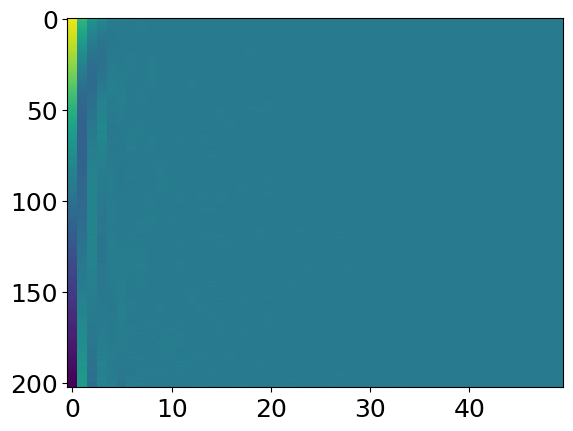

In [72]:
plt.imshow(normss_pca,aspect="auto",interpolation="none")

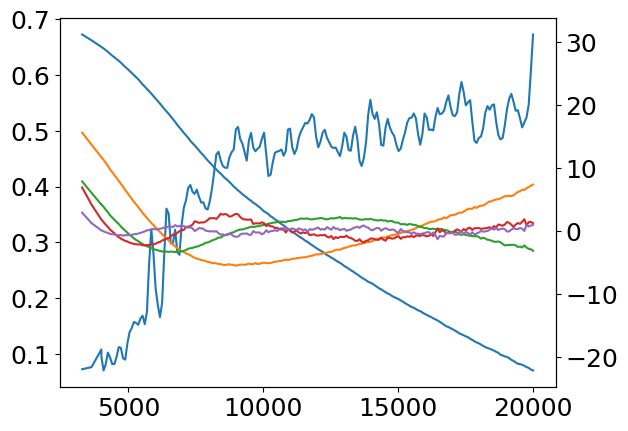

In [73]:
plt.plot(steps,caccs)
plt.twinx()
for i in range(5):
    plt.plot(steps,normss_pca[:,i])
#plt.plot(steps,normss_n[:,1],c="b")

#plt.ylim(bottom=0)

In [78]:
#over_conditioning_colors=[[0.3,0.3,0.7],[0.2,0.2,0.8],[0.1,0.1,0.9],[0.0,0.0,1.0],[-0.1,-0.1,1.1]]
over_conditioning_colors=[[0.4,0.4,0.6],[0.3,0.3,0.7],[0.2,0.2,0.8]]
steps=[]
caccs=[]
saccs=[]
genss=[]
accss=[]
for i in tqdm.trange(len(ckpts)):
    step=ckpts[i]["step"]
    cacc=ckpts[i]["color_acc"]
    sacc=ckpts[i]["size_acc"]
    model.load_state_dict(ckpts[i]["ckpt"])
    gens=[]
    accs=[]
    for over_conditioning_color in over_conditioning_colors:
        gens_=model.generate(c=torch.tensor([0.,0.,0.,0., *over_conditioning_color, 0.3, 0.,0.,0.])[None].repeat(64,1).to(device))
        accs_=torch.stack(classifier.classify(gens_,return_probs=True),dim=0)
        accs.append(accs_[:,:,1].detach().cpu().numpy())
        gens.append(gens_.detach().cpu().numpy())
    steps.append(step)
    caccs.append(cacc)
    saccs.append(sacc)
    accs=np.stack(accs,axis=0)
    accss.append(accs)
    gens=np.stack(gens,axis=0)
    genss.append(gens)
steps=np.array(steps)
caccs=np.array(caccs)
saccs=np.array(saccs)
accss=np.stack(accss,axis=0)
genss=np.stack(genss,axis=0)
steps.shape,caccs.shape,accss.shape,genss.shape

  1%|          | 2/203 [00:09<15:44,  4.70s/it]


KeyboardInterrupt: 

In [66]:
mean_accs=accss.mean(-1)
mean_accs.shape

(203, 3, 2)

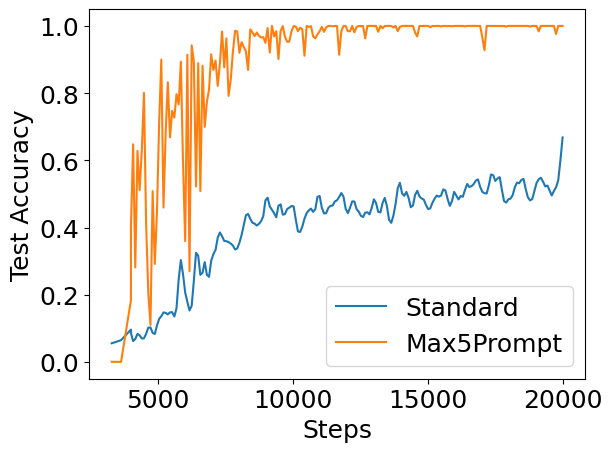

In [67]:
#plt.plot(steps,caccs)
#plt.plot(steps,saccs)
plt.plot(steps,caccs*saccs,label="Standard")
plt.plot(steps,mean_accs.prod(-1).max(1),label="Max5Prompt")
#plt.plot(steps,mean_accs[:,0,1])
#plt.plot(steps,mean_accs[:,4,1])
plt.xlabel("Steps")
plt.ylabel("Test Accuracy")
plt.legend()
plt.savefig("../figures/final/max5prompt.png")

In [599]:
maxaccs=accs.max(0)
maxaccs.T

array([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       7.0704260e-07, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 9.9999988e-01, 1.0000000e+00,
       1.0000000e+00, 9.9999988e-01, 9.9999988e-01, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 9.9999976e-01, 1.0000000e+00, 1.0000000e+00,
       5.8920904e-08, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       9.9999964e-01, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e

In [604]:
accs.max(0).mean()

0.96874994

In [602]:
accs.mean(1)

array([0.2654611 , 0.3099429 , 0.40625256, 0.54687494, 0.71875125],
      dtype=float32)

In [591]:
classifier_ckpt_path="../data/images_1/2x2_final2/classifier_combined.pth"
n_classes=[2,2]
net=networks.CUNet(shape=(3,32,32),out_channels=64,chs=[32,32,32],norm_groups=4)
classifier=models.Classifier(net=net,n_classes=n_classes)
classifier=classifier.to(device)
classifier.load_state_dict(torch.load(classifier_ckpt_path))
classifier=classifier.eval()

In [585]:
i=30
model=utils.get_model(config)
model.load_state_dict(ckpts[i]["ckpt"])
model.to(device)
model.eval()
gens=model.generate(c=torch.tensor([0.,0.,0.,0., 0.1,0.1,0.9, 0.3, 0.,0.,0.])[None].repeat(16,1).to(device))
gens=gens.detach().cpu().numpy()
print(ckpts[i]["step"])

4582


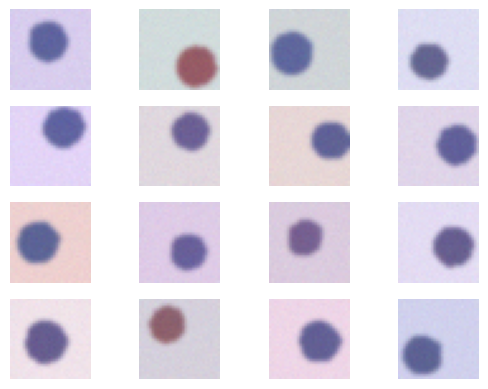

In [586]:
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.imshow(np.clip(gens[i*4+j].transpose(1,2,0),0,1))
        plt.axis("off")

In [189]:
save_steps1=(np.linspace(np.sqrt(50),np.sqrt(2400),10)**2).astype(int).tolist()
save_steps2=(np.linspace(np.sqrt(2500),np.sqrt(15000),200)**2).astype(int).tolist()
save_steps=save_steps1+save_steps2
len(save_steps),np.array(save_steps)

(210,
 array([   50,   137,   268,   442,   660,   921,  1226,  1574,  1965,
         2400,  2500,  2536,  2573,  2610,  2647,  2685,  2723,  2761,
         2799,  2838,  2877,  2916,  2956,  2995,  3035,  3076,  3116,
         3157,  3198,  3239,  3281,  3323,  3365,  3407,  3450,  3493,
         3536,  3580,  3623,  3667,  3711,  3756,  3801,  3846,  3891,
         3937,  3982,  4029,  4075,  4122,  4168,  4216,  4263,  4311,
         4359,  4407,  4455,  4504,  4553,  4603,  4652,  4702,  4752,
         4802,  4853,  4904,  4955,  5006,  5058,  5110,  5162,  5215,
         5267,  5320,  5374,  5427,  5481,  5535,  5589,  5644,  5699,
         5754,  5809,  5865,  5921,  5977,  6033,  6090,  6147,  6204,
         6262,  6320,  6378,  6436,  6495,  6553,  6613,  6672,  6732,
         6791,  6852,  6912,  6973,  7034,  7095,  7156,  7218,  7280,
         7342,  7405,  7468,  7531,  7594,  7658,  7722,  7786,  7850,
         7915,  7980,  8045,  8111,  8176,  8242,  8309,  8375,  8442,


210

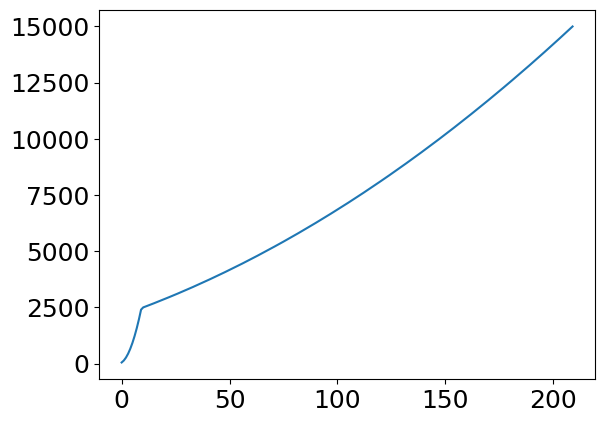

In [190]:
plt.plot(save_steps)
len(save_steps)

In [176]:
save_steps1=(np.linspace(np.sqrt(50),np.sqrt(2299),10)**2).astype(int).tolist()
save_steps2=np.linspace(2300,10000,200).astype(int).tolist()
save_steps3=(np.linspace(np.sqrt(10001),np.sqrt(15000),10)**2).astype(int).tolist()
save_steps=save_steps1+save_steps2+save_steps3
np.array(save_steps)

array([   50,   134,   260,   428,   636,   886,  1178,  1510,  1884,
        2299,  2300,  2338,  2377,  2416,  2454,  2493,  2532,  2570,
        2609,  2648,  2686,  2725,  2764,  2803,  2841,  2880,  2919,
        2957,  2996,  3035,  3073,  3112,  3151,  3189,  3228,  3267,
        3306,  3344,  3383,  3422,  3460,  3499,  3538,  3576,  3615,
        3654,  3692,  3731,  3770,  3809,  3847,  3886,  3925,  3963,
        4002,  4041,  4079,  4118,  4157,  4195,  4234,  4273,  4312,
        4350,  4389,  4428,  4466,  4505,  4544,  4582,  4621,  4660,
        4698,  4737,  4776,  4815,  4853,  4892,  4931,  4969,  5008,
        5047,  5085,  5124,  5163,  5202,  5240,  5279,  5318,  5356,
        5395,  5434,  5472,  5511,  5550,  5588,  5627,  5666,  5705,
        5743,  5782,  5821,  5859,  5898,  5937,  5975,  6014,  6053,
        6091,  6130,  6169,  6208,  6246,  6285,  6324,  6362,  6401,
        6440,  6478,  6517,  6556,  6594,  6633,  6672,  6711,  6749,
        6788,  6827,

220

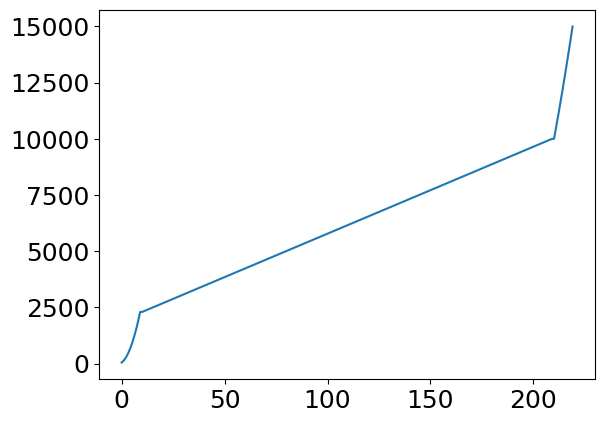

In [65]:
plt.plot(save_steps)
len(save_steps)

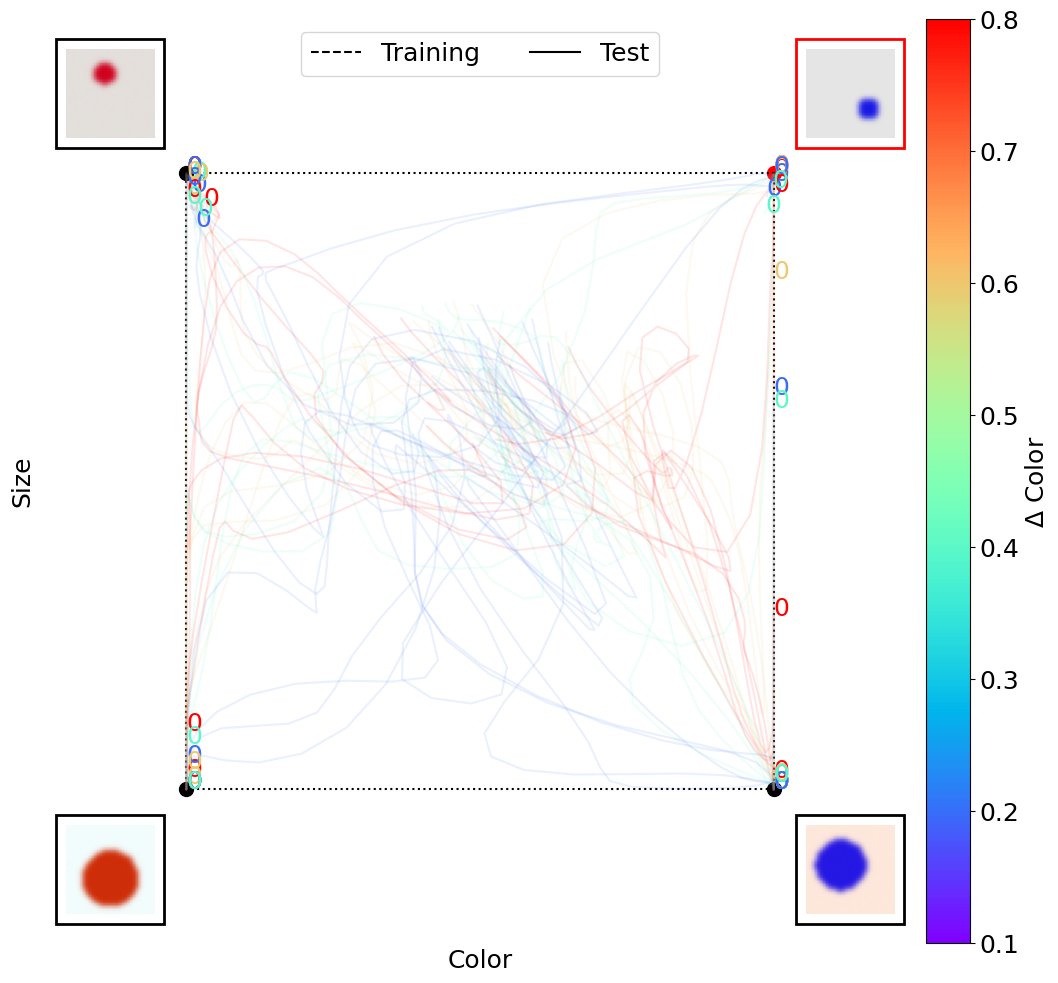

In [89]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)

plot_star=False
plot_singles=True
plot_mean=False
single_seeds=[0,100,200,300,400]

trajs_trss=[]
trajs_tess=[]
sep_cols=[]
sep_sizes=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_size=key[1]
    sep_cols.append(float(sep_col))
    sep_sizes.append(float(sep_size))
    #if sep_col not in sel:
    #    continue
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    seeds=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
        seeds.append(plot_data["seed"])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    color=sep_col_to_color(sep_col,cmap=cmap)

    if plot_mean:
        plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",c=color,markersize=5)
        for i in range(3):
            plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)

    if plot_singles:
        for i_seed,traj_te_single in enumerate(classprobs_pred_tes[:,:,:,l_te==3].mean(3)):
            seed=seeds[i_seed]
            if seed not in single_seeds:
                continue
            traj_smooth=sim.gaussian_filter1d(traj_te_single,2.0,axis=0,truncate=6.0)
            plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
            plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
        for i in range(3):
            for i_seed,traj_tr_single in enumerate(classprobs_pred_trs[:,:,:,l_tr==i].mean(3)):
                seed=seeds[i_seed]
                if seed not in single_seeds:
                    continue
                traj_smooth=sim.gaussian_filter1d(traj_tr_single,2.0,axis=0,truncate=6.0)
                plt.plot(traj_smooth[i_step_min:,0],traj_smooth[i_step_min:,1],c=color,alpha=0.1)
                plt.annotate(str(seed),(traj_smooth[-1,0],traj_smooth[-1,1]),c=color)
    if plot_star:
        print("star step",save_steps[i_star])
        i_star=20
        plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
        for i in range(3):
            plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)

trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
sep_cols=np.array(sep_cols)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
images=[]
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    images.append(image)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)
images=np.stack(images,axis=0)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Color")
#plt.savefig("../figures/final/training_dynamics_sep_col_wd=0.05.png")

In [142]:
"""
save_dict={"trajs_trss":trajs_trss,
"trajs_tess":trajs_tess,
"sep_cols":sep_cols,
"images":images}
torch.save(save_dict,"./trajs.pth")
"""

In [143]:
#single

In [144]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
save_steps=plot_datas[0]["save_steps"]
save_steps[i_step_min]

500

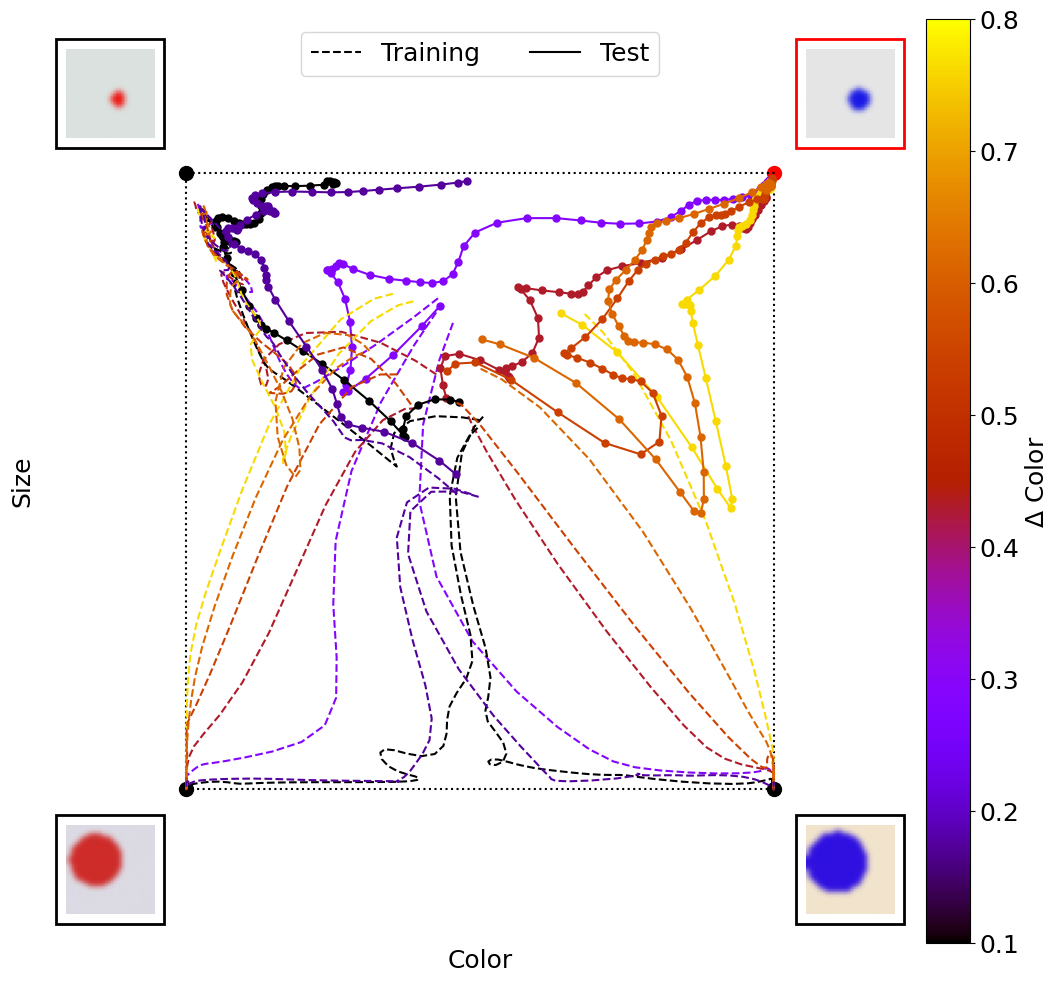

In [7]:
fig=plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
trajs_trss=[]
trajs_tess=[]
sep_cols=[]
for key in plot_datass.keys():
    sep_col=key[0]
    if sep_col not in ["0.1","0.174","0.284","0.432","0.542","0.616","0.763"]:#"0.211":#"0.763":#"0.211":#"0.763":#0.763
        continue
    sep_cols.append(float(sep_col))
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))#.mean(3))#
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))#.mean(3)#

    #trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=2,truncate=6.0)
    #trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=1,truncate=6.0)
    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1,truncate=6.0)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_te)
    color=sep_col_to_color(sep_col,cmap=cmap)
    i_star=10
    plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",markersize=5,c=color)
    #plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
        #plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)
    """
    for b in range(len(trajs_te)):
        plt.plot(trajs_te[b,i_step_min:,0],trajs_te[b,i_step_min:,1],marker="o",markersize=5)
        plt.plot(trajs_te[b,i_star,0],trajs_te[b,i_star,1],marker="*",c="r",markersize=20)
        #for i in range(3):
        #    plt.plot(trajs_trs[i,b,i_step_min:,0],trajs_trs[i,b,i_step_min:,1],ls="--",c=color)
        #    plt.plot(trajs_trs[i,b,i_star,0],trajs_trs[i,b,i_star,1],marker="*",c="r",markersize=20)
    """
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Color")
#plt.savefig("../figures/final/training_dynamics_sep_col_wd=0.05.png")

In [183]:
import copy

In [184]:
import matplotlib.animation as animation
fig_=copy.deepcopy(fig)
ax=fig_.get_axes()[0]
i_star=0
plots=[]
for trajs_te in trajs_tess:
    plots.extend(ax.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20))
for trajs_trs in trajs_trss:
    for i in range(3):
        plots.extend(ax.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20))

def update(step):
    c=0
    for i in range(len(trajs_tess)):
        plots[i].set_data(trajs_tess[i][step,0],trajs_tess[i][step,1])
        c+=1
    for i in range(len(trajs_trss)):
        for j in range(3):
            plots[c+3*i+j].set_data(trajs_trss[i][j,step,0],trajs_trss[i][j,step,1])
    return plots

ani = animation.FuncAnimation(fig_, update, frames=range(0,60), blit=True)
ani.save("../figures/final/training_dynamics.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_2993907/767120046.py:15: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plots[i].set_data(trajs_tess[i][step,0],trajs_tess[i][step,1])
/tmp/ipykernel_2993907/767120046.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  plots[c+3*i+j].set_data(trajs_trss[i][j,step,0],trajs_trss[i][j,step,1])


In [ ]:

i_star=10
ax.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
for i in range(3):
    fig_.gca().plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)
fig_

In [ ]:

i_star=10
plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
for i in range(3):
    plt.plot(trajs_trs[i,i_star,0],trajs_trs[i,i_star,1],marker="*",c="r",markersize=20)

In [52]:
sep_cols=np.array(sep_cols)

In [46]:
trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
displacement_trss=np.linalg.norm(np.gradient(trajs_trss,save_steps,axis=2),axis=3)
displacement_tess=np.linalg.norm(np.gradient(trajs_tess,save_steps,axis=1),axis=2)

(20, 3, 60, 2)

In [88]:
displacement_trss_m=displacement_trss.mean((0,1))
displacement_trss_s=displacement_trss.std((0,1),ddof=1)
displacement_trss_cm=displacement_trss.mean(1)
log_displacement_trss_cm=np.log(displacement_trss_cm)

displacement_tess_m=displacement_tess.mean(0)
displacement_tess_s=displacement_tess.std(0,ddof=1)
displacement_tess_cm=displacement_tess
log_displacement_tess_cm=np.log(displacement_tess_cm)

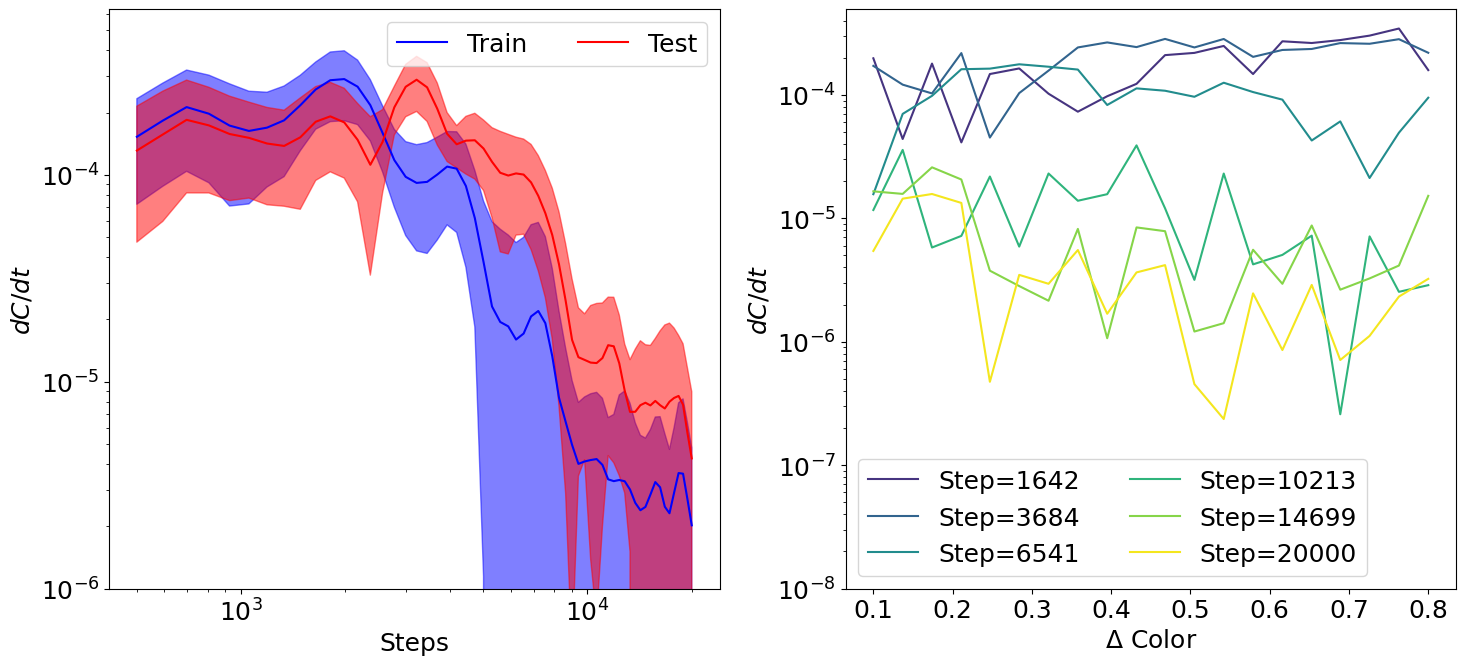

In [117]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(save_steps,displacement_trss_m,c="b",label="Train")
plt.fill_between(save_steps,displacement_trss_m-displacement_trss_s,displacement_trss_m+displacement_trss_s,alpha=0.5,color="b")
plt.plot(save_steps,displacement_tess_m,c="r",label="Test")
plt.fill_between(save_steps,displacement_tess_m-displacement_tess_s,displacement_tess_m+displacement_tess_s,alpha=0.5,color="r")
plt.yscale("log")
plt.xscale("log")
plt.ylim(bottom=1e-6)
plt.ylabel(r"$dC/dt$")
plt.xlabel("Steps")
plt.legend(ncol=2)

plt.subplot(1,2,2)
for i in [9,19,29,39,49,59]:
    indsort=np.argsort(sep_cols)
    step=save_steps[i]
    #_=plt.plot(sep_cols[indsort],displacement_trss_cm[:,i][indsort],c=matplotlib.colormaps["viridis"](i/60),ls="--",alpha=0.5)
    _=plt.plot(sep_cols[indsort],displacement_tess_cm[:,i][indsort],c=matplotlib.colormaps["viridis"](i/60),label=f"Step={step}")
plt.yscale("log")
plt.ylim(bottom=1e-8)
plt.ylabel(r"$dC/dt$")
plt.xlabel(r"$\Delta$ Color")
plt.legend(ncol=2)

plt.tight_layout()
#plt.savefig("../figures/final/dCdt.png")

In [80]:
log_steps=np.log(save_steps)

In [99]:
#variance explained from the two dimensions
import sklearn.linear_model as sklin
import sklearn.metrics as skmet
x_sep_cols=sep_cols[:,None].repeat(60,axis=1).reshape(-1,1)
x_log_steps=log_steps[None,:].repeat(20,axis=0).reshape(-1,1)
x_joint=np.concatenate([x_sep_cols,x_log_steps],axis=1)
y=log_displacement_trss_cm.reshape(-1,1)

linreg_sep_cols=sklin.LinearRegression()
linreg_sep_cols.fit(x_sep_cols,y)
r2_sep_cols=skmet.r2_score(y,linreg_sep_cols.predict(x_sep_cols))

linreg_log_steps=sklin.LinearRegression()
linreg_log_steps.fit(x_log_steps,y)
r2_log_steps=skmet.r2_score(y,linreg_log_steps.predict(x_log_steps))

linreg_joint=sklin.LinearRegression()
linreg_joint.fit(x_joint,y)
r2_joint=skmet.r2_score(y,linreg_joint.predict(x_joint))

r2_sep_cols,r2_log_steps,r2_joint

(0.010445819627637465, 0.7922229880231804, 0.8026688060810088)

In [48]:
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2_final2/sc4ss4/*/seed=*"):
for fol in glob.glob("../data/images_1/2x2_final2/size_sweep/*/seed=*"):
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    plot_data_file=os.path.join(fol,"plot_data.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
    #if "seed=0" in fol:
    #    print(sep_col)
len(plot_datass),c

(20, 75)

In [49]:
fol

'../data/images_1/2x2_final2/size_sweep/sep_col=0.4_sep_size=0.316/seed=0'

In [50]:
config=utils.load_config('../data/images_1/2x2_final2/size_sweep/sep_col=0.4_sep_size=0.389/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)

In [55]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
plot_datas[0]["save_steps"][i_step_min]

594

In [56]:
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap="cubehelix"
norm = mcolors.Normalize(vmin=0.2, vmax=0.389)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

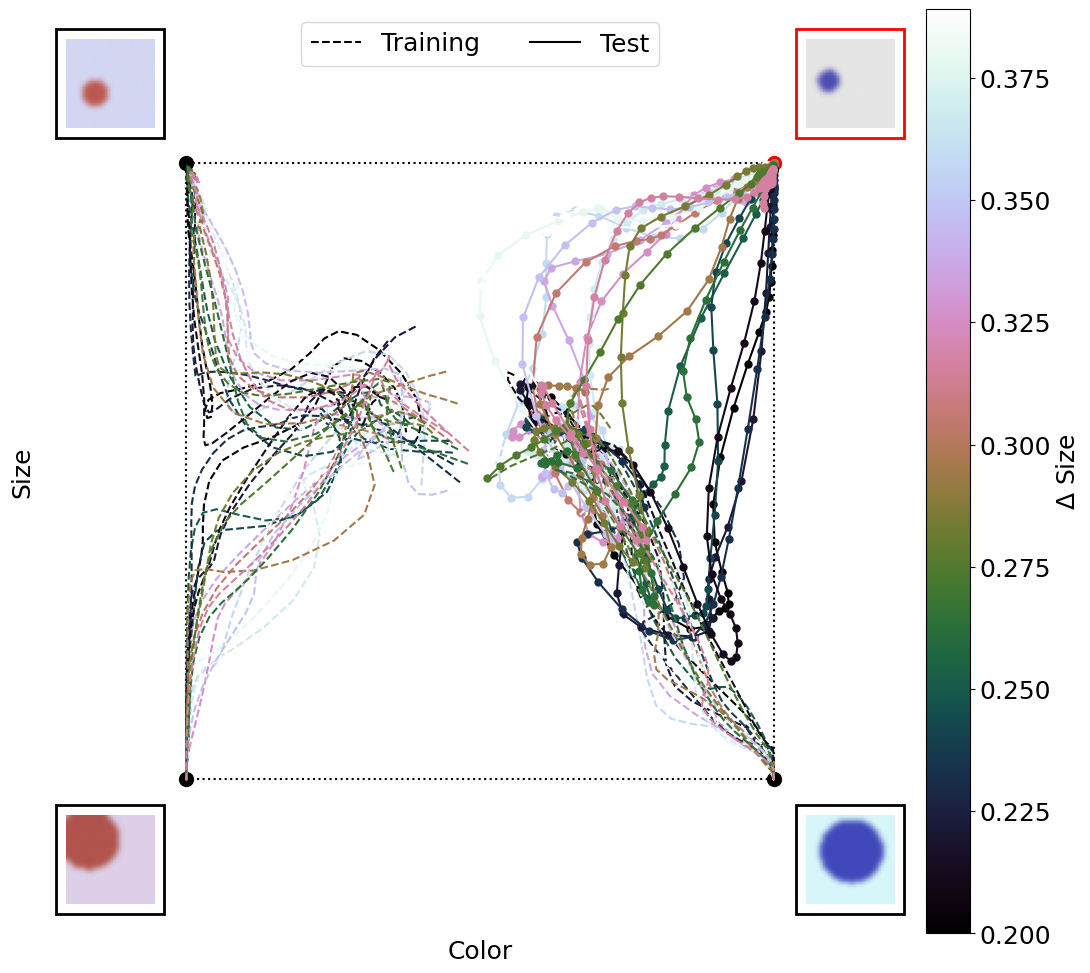

In [57]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
for key in plot_datass.keys():
    sep_size=key[1]
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0)
    color=sep_col_to_color(sep_size,cmap=cmap)
    plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",c=color,markersize=5)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Size")
plt.savefig("../figures/final/training_dynamics_sep_size.png")

In [135]:
plot_datass={}
c=0
for fol in glob.glob("../data/images_1/2x2_final2/detailed/*/seed=*"):
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    if (sep_col,sep_size) not in [("0.4","0.333"),("0.8","0.333"),("0.2","0.333"),("0.4","0.2"),("0.4","0.4")]:
        continue

    plot_data_file=os.path.join(fol,"plot_data.pth")
    if not os.path.exists(plot_data_file):
        continue
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_datass.setdefault((sep_col,sep_size),[]).append(plot_data)
    c+=1
    #if "seed=0" in fol:
    #    print(sep_col)
len(plot_datass),c

(5, 25)

In [136]:
config=utils.load_config('../data/images_1/2x2_final2/detailed/sep_col=0.4_sep_size=0.333/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,forgen=True)

In [137]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
plot_datas[0]["save_steps"][i_step_min]

10

In [138]:
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap="gnuplot"
norm = mcolors.Normalize(vmin=0.2, vmax=0.389)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

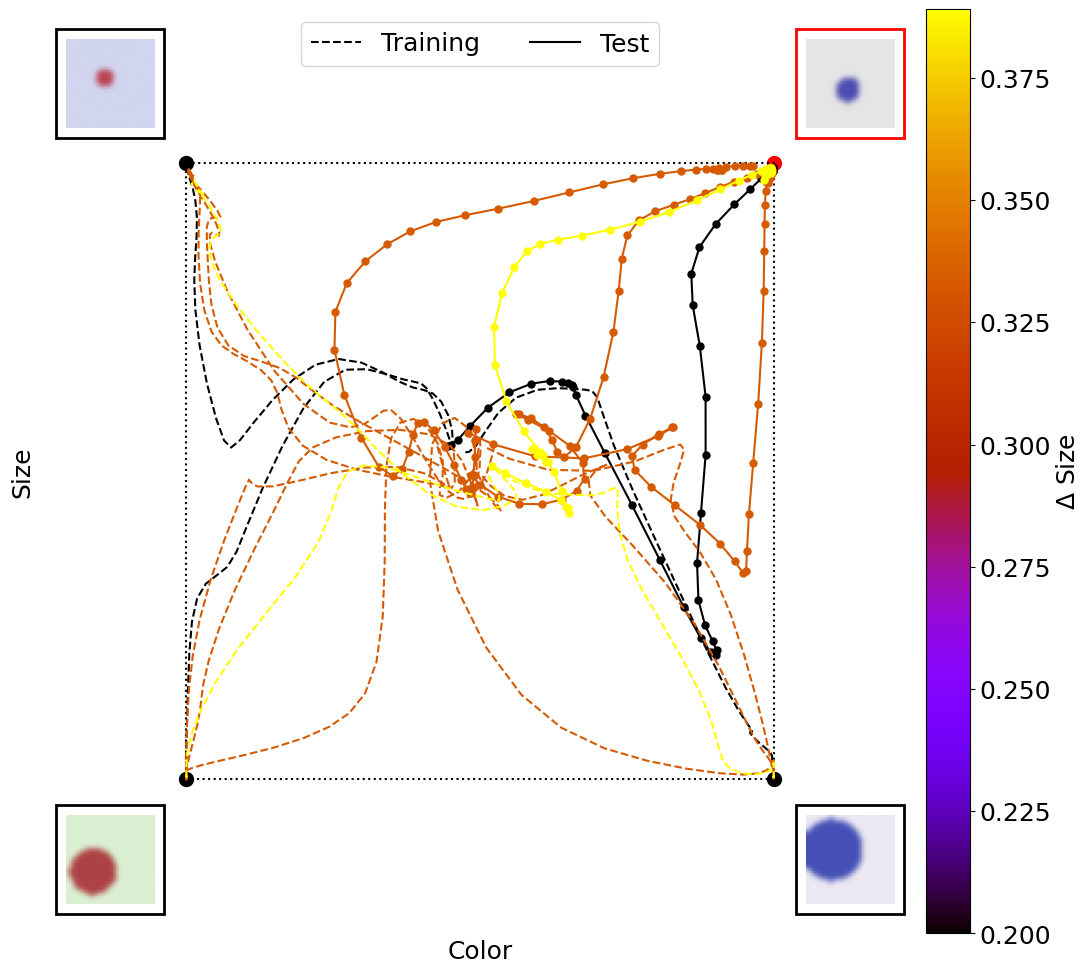

In [139]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
for key in plot_datass.keys():
    sep_size=key[1]
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)
    #loop for tr
    trajs_trs=[]
    for i in range(3):
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==i].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    #in 2D only 1 test
    trajs_te=classprobs_pred_tes[:,:,:,l_te==3].mean((0,3))

    trajs_trs=sim.gaussian_filter1d(trajs_trs,2.0,axis=1)
    trajs_te=sim.gaussian_filter1d(trajs_te,2.0,axis=0)
    color=sep_col_to_color(sep_size,cmap=cmap)
    plt.plot(trajs_te[i_step_min:,0],trajs_te[i_step_min:,1],marker="o",c=color,markersize=5)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,0],trajs_trs[i,i_step_min:,1],ls="--",c=color)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Size")
plt.xlabel("Color")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Size")
plt.savefig("../figures/final/training_dynamics_scss.png")

ckpt stuff

In [ ]:
plot_datass={}
c=0
for fol in glob.glob("../data/images_1/2x2_final2/"):
    pass

In [60]:
ckpts=plot_datas[0]["ckpts"]
ckpt_keys=ckpts[0].keys()
tckpt={}
for key in ckpt_keys:
    if "model.score_model" not in key:
        continue
    key_=key.replace("model.score_model.","")
    tckpt[key_]=[]
    for ckpt in ckpts:
        tckpt[key_].append(ckpt[key])  
    tckpt[key_]=torch.stack(tckpt[key_],axis=0).cpu().numpy()
    print(key_,tckpt[key_].shape)

embed_t_conditioning.0.weight (60, 256, 64)
embed_t_conditioning.0.bias (60, 256)
embed_t_conditioning.2.weight (60, 256, 256)
embed_t_conditioning.2.bias (60, 256)
embedders.0.0.0.weight (60, 1024, 256)
embedders.0.0.0.bias (60, 1024)
embedders.0.0.2.weight (60, 1024, 1024)
embedders.0.0.2.bias (60, 1024)
embedders.0.1.0.weight (60, 1024, 2)
embedders.0.1.0.bias (60, 1024)
embedders.0.1.2.weight (60, 1024, 1024)
embedders.0.1.2.bias (60, 1024)
layers.0.weight (60, 1024, 2)
layers.0.bias (60, 1024)
layers.1.weight (60, 2, 1024)
layers.1.bias (60, 2)


In [61]:
tckpt['embedders.0.1.2.weight'].shape

(60, 1024, 1024)

In [62]:
eigvs=np.linalg.eigvals(tckpt['embedders.0.1.2.weight'])
eigvs.shape

(60, 1024)

In [63]:
eigvs_abs=np.abs(eigvs)**2

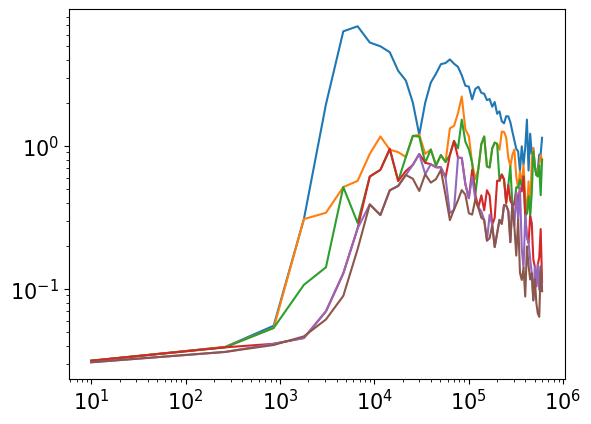

In [64]:
plt.plot(save_steps,eigvs_abs[:,0])
plt.plot(save_steps,eigvs_abs[:,1])
plt.plot(save_steps,eigvs_abs[:,2])
plt.plot(save_steps,eigvs_abs[:,3])
plt.plot(save_steps,eigvs_abs[:,4])
plt.plot(save_steps,eigvs_abs[:,5])
plt.xscale("log")
plt.yscale("log")

In [65]:
def mMn(vals):
    m=vals.min()
    M=vals.max()
    return (vals-m)/(M-m)

Text(0, 0.5, 'Eigenvalue')

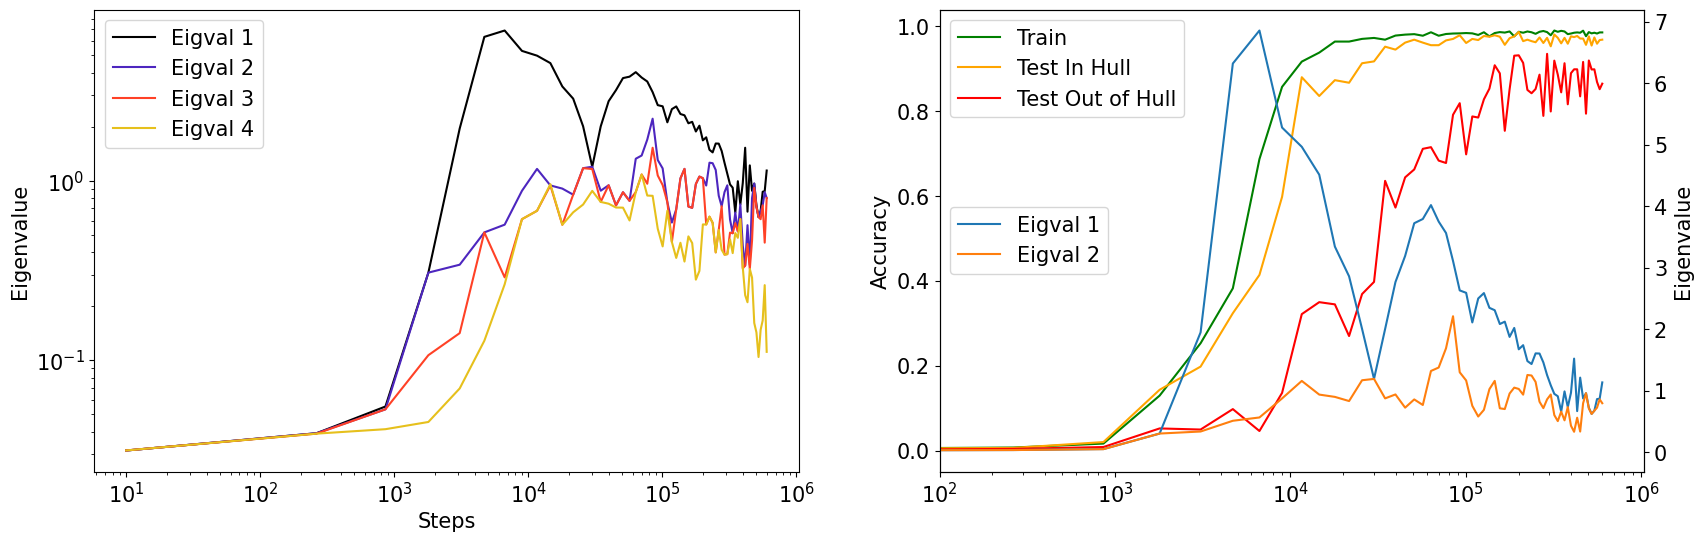

In [66]:
x_left=100
plt.figure(figsize=(20,6))
plt.rcParams.update({'font.size': 15})
plt.subplot(1,2,1)
cmap=plt.get_cmap("CMRmap")
for i in range(4):
    plt.plot(save_steps,eigvs_abs[:,i],color=cmap(i/4),label="Eigval "+str(i+1))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
plt.legend()

plt.subplot(1,2,2)
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
plt.xscale("log")
plt.legend()
plt.xlim(left=x_left)
plt.ylabel("Accuracy")
plt.twinx()
plt.plot(save_steps,eigvs_abs[:,0],label="Eigval 1")
plt.plot(save_steps,eigvs_abs[:,1],label="Eigval 2")
plt.legend(loc="center left")
plt.xlabel("Steps")
plt.ylabel("Eigenvalue")
#plt.savefig("./figures/eigen_predict.png")

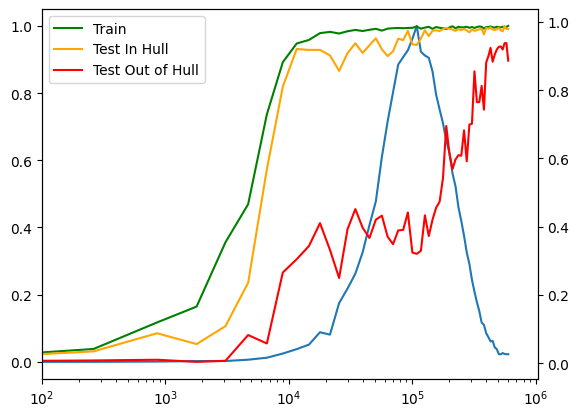

In [20]:
x_left=100
min_vlb=plot_data["min_vlb"]
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.weight'][:,:,0],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.0.bias'][:,:],axis=1))
#plt.plot(save_steps,np.linalg.norm(tckpt['embedders.0.1.2.bias'][:,:],axis=1))
plt.plot(save_steps,mMn(eigvs_abs[:,0]),label="Max. Eigval. of Cond. Proj.")
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.weight'][:,:,0],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.0.bias'],axis=1)))
#plt.plot(save_steps,mMn(np.linalg.norm(tckpt['layers.1.bias'],axis=1)))
plt.xscale("log")
plt.xlim(left=x_left)
#plt.twinx()
#plt.plot(save_steps,val_losses-min_vlb,c="green",alpha=0.5)
#plt.plot(save_steps,te_losses-min_vlb,c="red",alpha=0.5)
#plt.yscale("log")
plt.twinx()
plt.plot(save_steps,triaccm,c="green",label="Train")
plt.plot(save_steps,inhaccm,c="orange",label="Test In Hull")
plt.plot(save_steps,oohaccm,c="red",label="Test Out of Hull")
#plt.plot(save_steps,acctr_m,c="green",ls="--")
#plt.plot(save_steps,accte_m,c="red",ls="--")
plt.legend()
